In [ ]:
import matplotlib.pyplot as plt
from datetime import date, timedelta
from shapely import wkt
import geopandas as gpd
import os
import rasterio
import json
import cv2
import numpy as np
import pandas as pd
from pyproj import Transformer
import rasterio

In [ ]:
# download from katasteramt
bauwerke_path = "/home/lennart/Downloads/SHP_BE_ALKIS/2025-10-13_SHP_BE_ALKIS/SHP_BE_ALKIS_processed/Bauwerke_Flaechen.shp"
nutzung_path = "/home/lennart/Downloads/SHP_BE_ALKIS/2025-10-13_SHP_BE_ALKIS/SHP_BE_ALKIS_processed/Nutzung_Flaechen.shp"

bauwerke = gpd.read_file(bauwerke_path)
nutzung = gpd.read_file(nutzung_path)

In [105]:
sport = nutzung[nutzung["BEZEICH"] == "AX_SportFreizeitUndErholungsflaeche"].dropna(axis=1, how="all").set_index("UUID")
"""sport = sport[sport["BEZFKT"].isin(
    [
        'Spielplatz, Bolzplatz', 
        'Gebäude- und Freifläche Sport, Freizeit und Erholung',
        'Sportanlage', 
        'Freizeitanlage'
    ]
)]"""

'sport = sport[sport["BEZFKT"].isin(\n    [\n        \'Spielplatz, Bolzplatz\', \n        \'Gebäude- und Freifläche Sport, Freizeit und Erholung\',\n        \'Sportanlage\', \n        \'Freizeitanlage\'\n    ]\n)]'

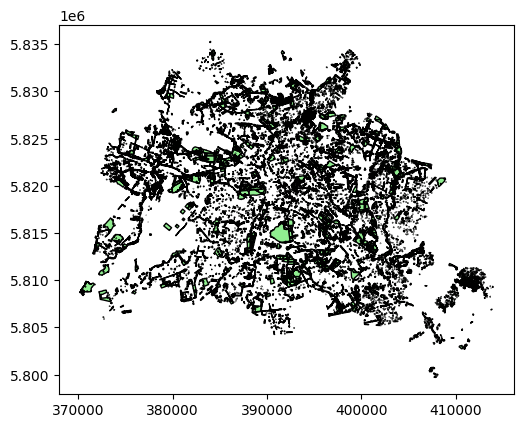

In [106]:
gdf = gpd.GeoDataFrame(sport, geometry='geometry')
gdf.plot(edgecolor='black', facecolor='lightgreen')
plt.show()

In [ ]:
# download from copernicus browser
mosaic_1 = "/home/lennart/Downloads/Sentinel-2_mosaic_2025_Q3_33UUU_0_0"
mosaic_2 = "/home/lennart/Downloads/Sentinel-2_mosaic_2025_Q3_33UVU_0_0"

In [283]:
with rasterio.open(os.path.join(mosaic_1, f'B02.tif')) as src:
    band = src.read(1)
    transform = src.transform
    height, width = band.shape
    rows, cols = np.indices((height, width))
    
    easting, northing = rasterio.transform.xy(transform, rows, cols)
    
    easting = np.array(easting)
    northing = np.array(northing)


transformer = Transformer.from_crs("EPSG:32633", "EPSG:4326", always_xy=True)

grid_longitude, grid_latitude = transformer.transform(easting, northing)
grid_longitude1 = grid_longitude.reshape((10008, 10008))
grid_latitude1 = grid_latitude.reshape((10008, 10008))

In [284]:
with rasterio.open(os.path.join(mosaic_2, f'B02.tif')) as src:
    band = src.read(1)
    transform = src.transform
    height, width = band.shape
    rows, cols = np.indices((height, width))
    
    easting, northing = rasterio.transform.xy(transform, rows, cols)
    
    easting = np.array(easting)
    northing = np.array(northing)


transformer = Transformer.from_crs("EPSG:32633", "EPSG:4326", always_xy=True)

grid_longitude, grid_latitude = transformer.transform(easting, northing)
grid_longitude2 = grid_longitude.reshape((10008, 10008))
grid_latitude2 = grid_latitude.reshape((10008, 10008))

In [158]:
def open_img(path_mosaic: str, band: int):
    raw = rasterio.open(os.path.join(path_mosaic, f'B0{band}.tif')).read(1)
    raw = np.where(raw == -32768, np.nan, raw)    
    min_val, max_val = np.nanmin(raw), np.nanmax(raw)
    normalized = (raw - min_val) / (max_val - min_val)
    return (normalized * 255).astype(np.uint8)

In [159]:
band1_2 = open_img(mosaic_1, 2)
band1_3 = open_img(mosaic_1, 3)
band1_4 = open_img(mosaic_1, 4)
band1_8 = open_img(mosaic_1, 8)

band2_2 = open_img(mosaic_2, 2)
band2_3 = open_img(mosaic_2, 3)
band2_4 = open_img(mosaic_2, 4)
band2_8 = open_img(mosaic_2, 8)

/tmp/ipykernel_67578/457524455.py:6: RuntimeWarning: invalid value encountered in cast
  return (normalized * 255).astype(np.uint8)


In [115]:
observations1 = rasterio.open(os.path.join(mosaic_1, 'observations.tif')).read(1) 
observations2 = rasterio.open(os.path.join(mosaic_2, 'observations.tif')).read(1) 

In [116]:
with open(os.path.join(mosaic_1, "userdata.json")) as file:
    userdata1 = json.load(file)

with open(os.path.join(mosaic_2, "userdata.json")) as file:
    userdata2 = json.load(file)

In [130]:
userdata1

{'@odata.context': '$metadata#Products(Attributes())',
 'Name': 'Sentinel-2_mosaic_2025_Q3_33UUU_0_0',
 'OriginDate': '2025-10-03T20:22:14.574Z',
 'PublicationDate': '2025-10-03T20:22:14.574Z',
 'ModificationDate': '2025-10-03T20:22:14.574Z',
 'EvictionDate': '9999-12-31T23:59:59.999Z',
 'ContentLength': None,
 'Online': True,
 'ContentType': 'application/octet-stream',
 'Link': 'https://sentinel2-mosaic-2025-07.s3.waw3-1.cloudferro.com/Global-Mosaics/Sentinel-2/S2MSI_L3__MCQ/2025/07/01/Sentinel-2_mosaic_2025_Q3_33UUU_0_0/',
 'QL_Path': None,
 'CollectionName': 'Global-Mosaics',
 'PathLevel2': 'Sentinel-2',
 'ProductType': 'S2MSI_L3__MCQ',
 'TargetFormat': 'EXTRACTED',
 'DecompressionStep': False,
 'CompresionType': None,
 'ContentDate': {'Start': '2025-07-01T00:00:00Z',
  'End': '2025-09-30T23:59:59Z'},
 'Checksum': None,
 'GeoFootprint': {'type': 'Polygon',
  'coordinates': [[[12.06583387839347, 52.31348451566856],
    [12.004760919773936, 53.21197782487871],
    [13.502737891597825,

In [117]:
coordinates1 = np.asarray(userdata1["GeoFootprint"]["coordinates"][0])
coordinates2 = np.asarray(userdata2["GeoFootprint"]["coordinates"][0])
coordinates1, coordinates2

(array([[12.06583388, 52.31348452],
        [12.00476092, 53.21197782],
        [13.50273789, 53.24022341],
        [13.53330758, 52.34083043],
        [12.06583388, 52.31348452]]),
 array([[13.53154677, 52.34080855],
        [13.50094041, 53.24020081],
        [15.0005995 , 53.24962646],
        [15.00058725, 52.34993373],
        [13.53154677, 52.34080855]]))

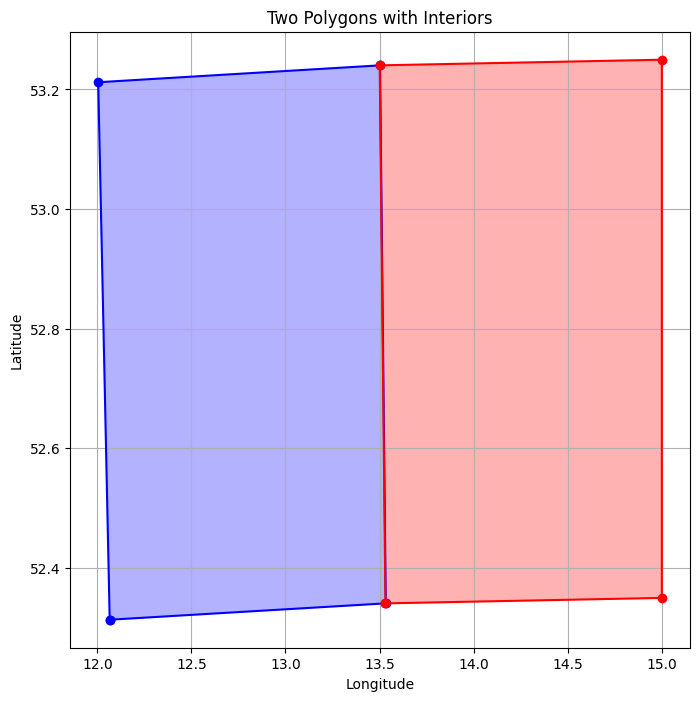

In [118]:
lons1 = coordinates1[:, 0]
lats1 = coordinates1[:, 1]

lons2 = coordinates2[:, 0]
lats2 = coordinates2[:, 1]

plt.figure(figsize=(8, 8))

plt.plot(lons1, lats1, 'bo-')
plt.fill(lons1, lats1, 'b', alpha=0.3)

plt.plot(lons2, lats2, 'ro-')
plt.fill(lons2, lats2, 'r', alpha=0.3)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Two Polygons with Interiors")

plt.grid(True)
plt.show()

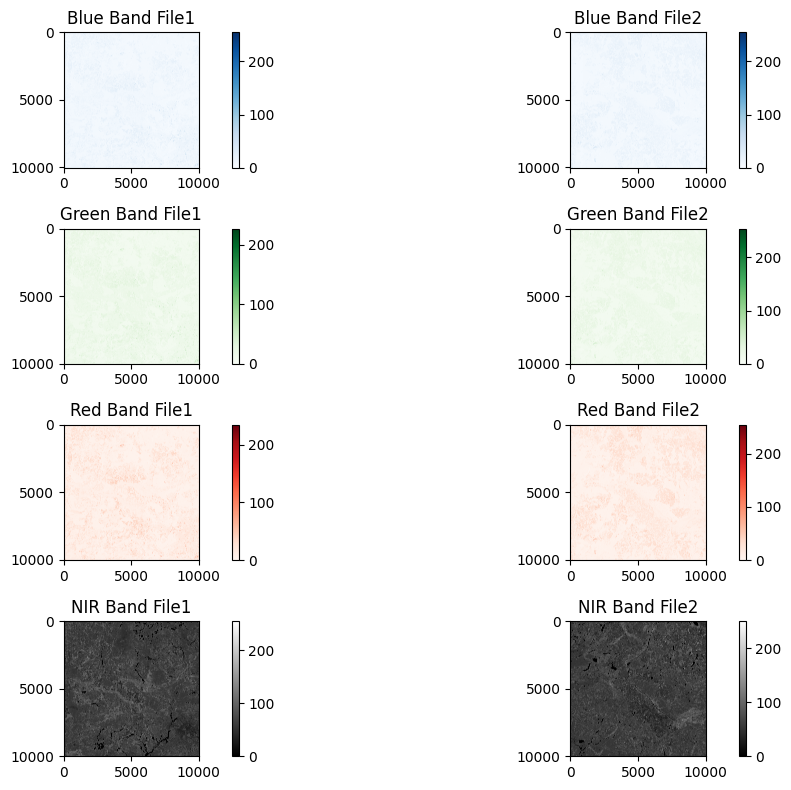

In [119]:
plt.figure(figsize=(12, 8))
plt.subplot(4, 2, 1)
plt.imshow(band1_2, cmap='Blues')
plt.title('Blue Band File1')
plt.colorbar()

plt.subplot(4, 2, 3)
plt.imshow(band1_3, cmap='Greens')
plt.title('Green Band File1')
plt.colorbar()

plt.subplot(4, 2, 5)
plt.imshow(band1_4, cmap='Reds')
plt.title('Red Band File1')
plt.colorbar()

plt.subplot(4, 2, 7)
plt.imshow(band1_8, cmap='gray')
plt.title('NIR Band File1')
plt.colorbar()

plt.subplot(4, 2, 2)
plt.imshow(band2_2, cmap='Blues')
plt.title('Blue Band File2')
plt.colorbar()

plt.subplot(4, 2, 4)
plt.imshow(band2_3, cmap='Greens')
plt.title('Green Band File2')
plt.colorbar()

plt.subplot(4, 2, 6)
plt.imshow(band2_4, cmap='Reds')
plt.title('Red Band File2')
plt.colorbar()

plt.subplot(4, 2, 8)
plt.imshow(band2_8, cmap='gray')
plt.title('NIR Band File2')
plt.colorbar()

plt.tight_layout()
plt.show()

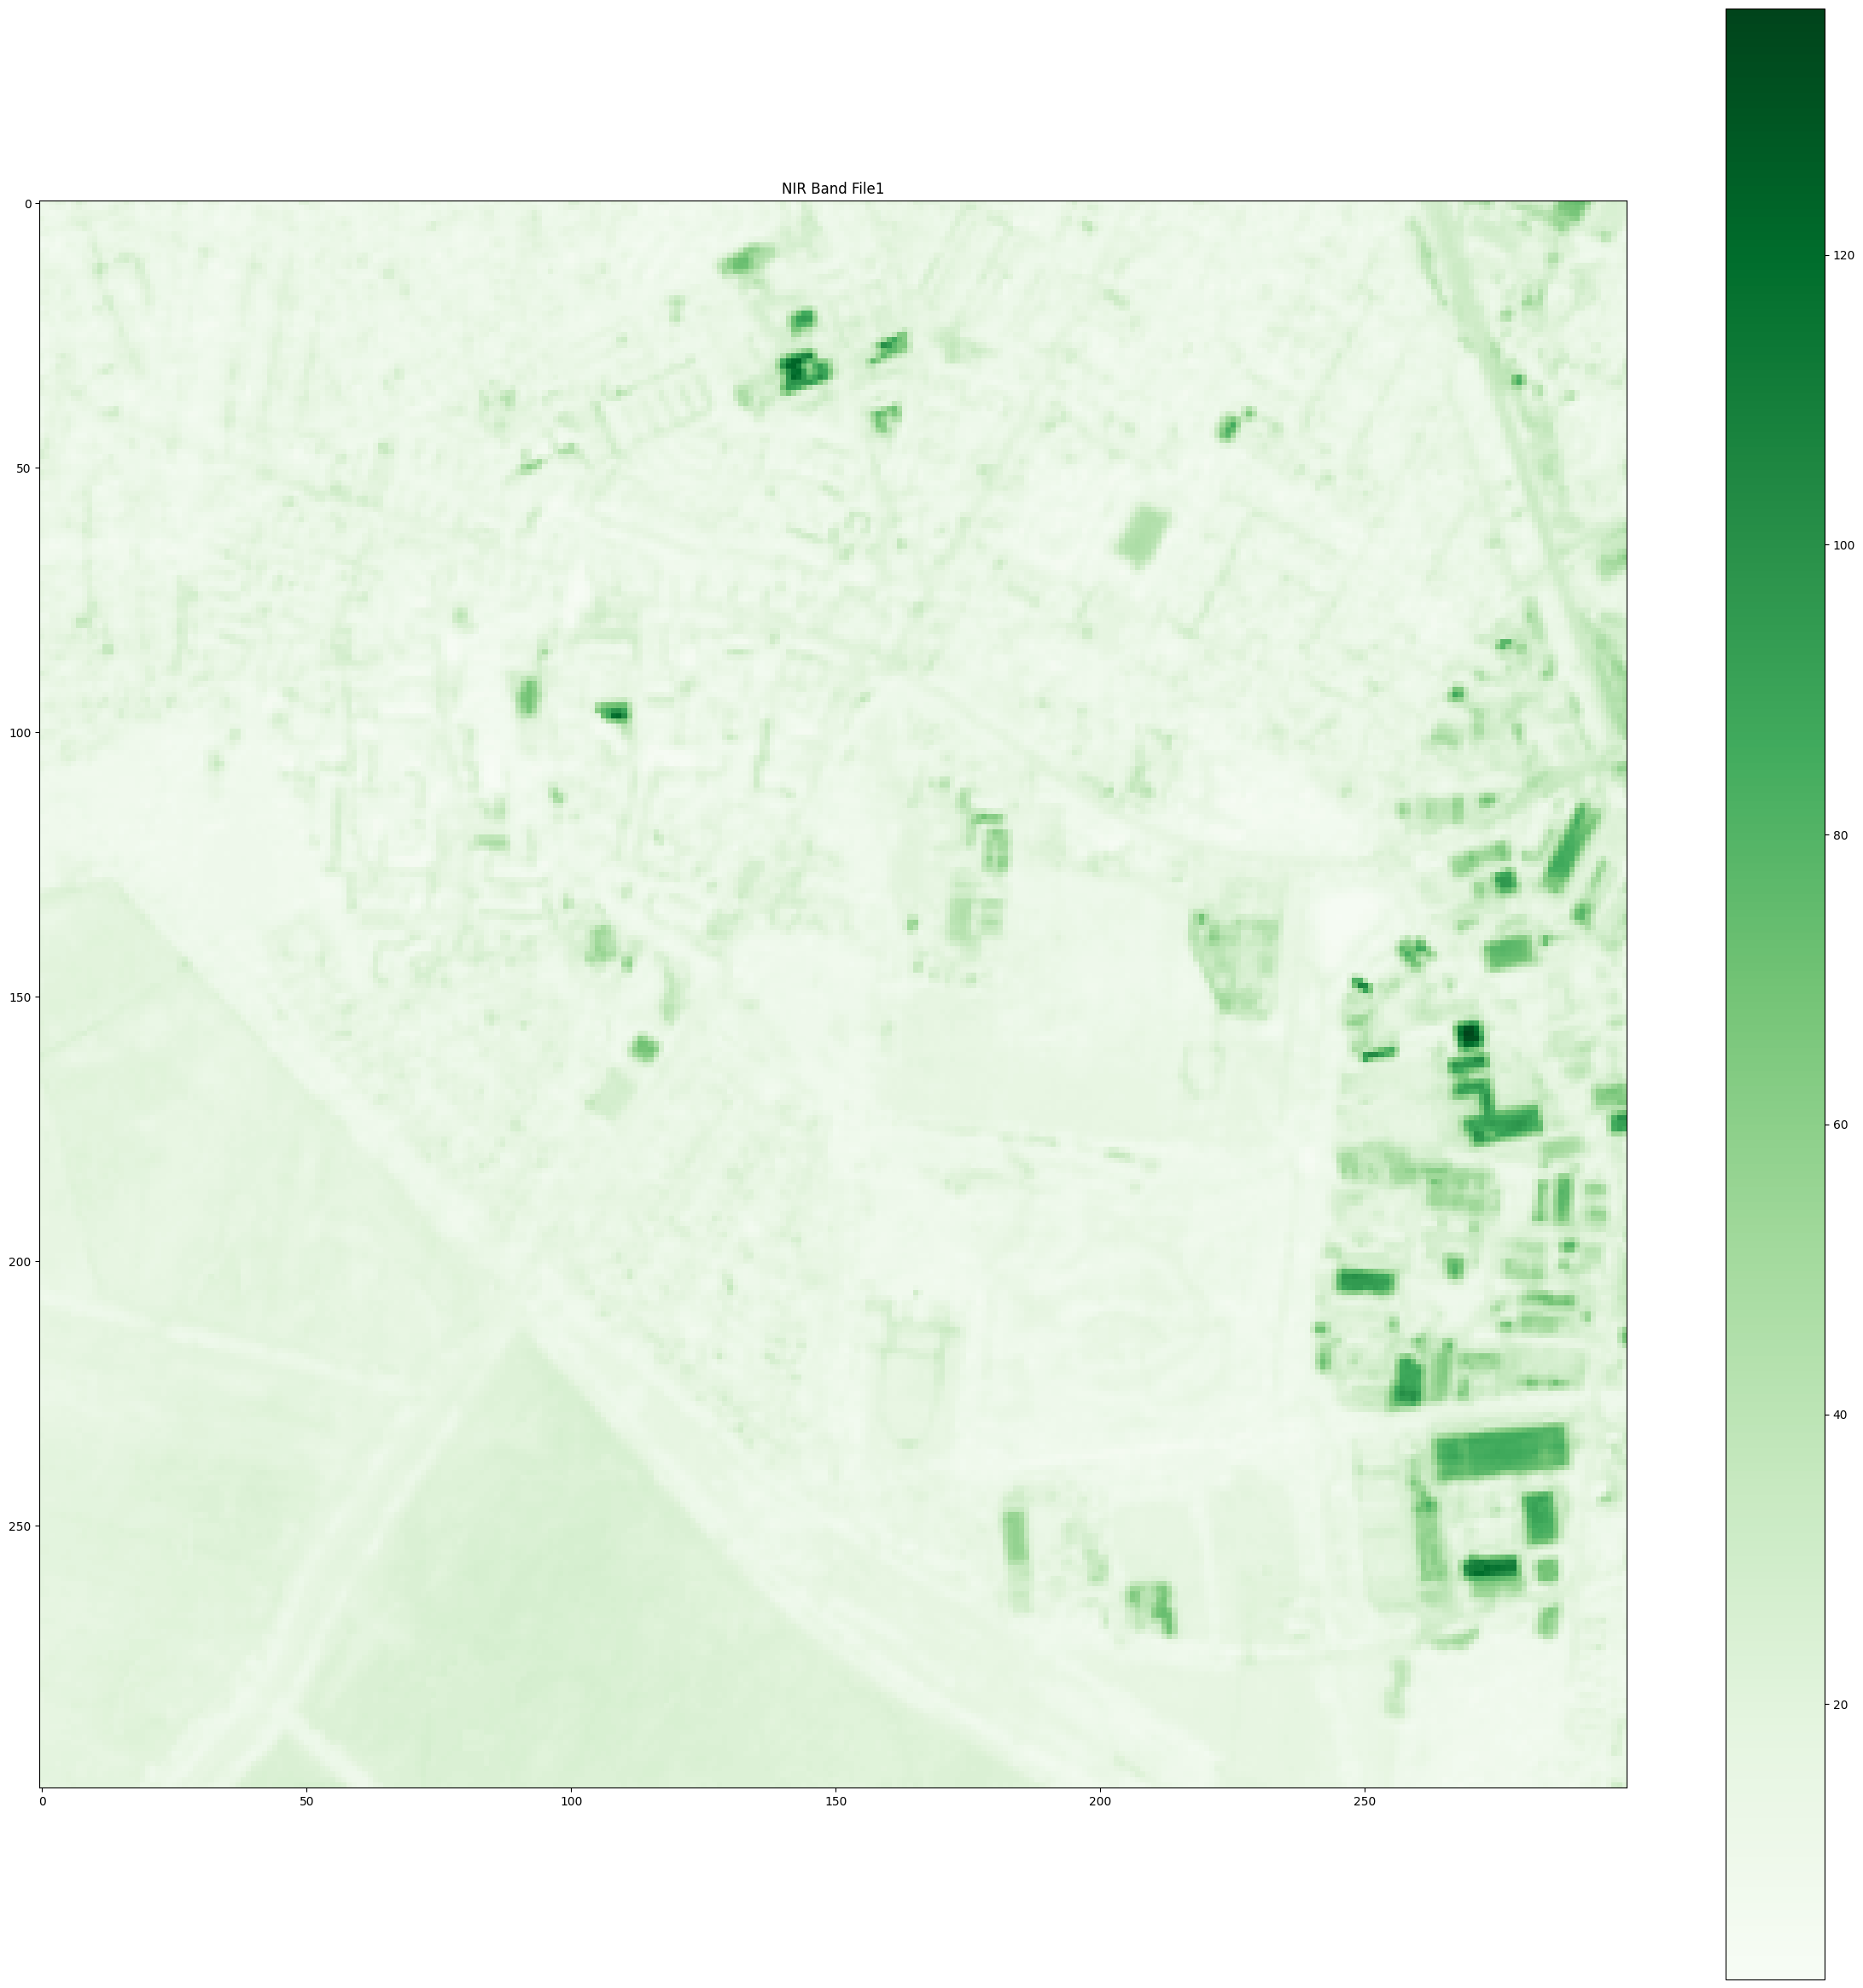

In [120]:
plt.figure(figsize=(30, 30))
plt.imshow(band1_3[9100:9400, 8700:9000], cmap='Greens')
plt.title('NIR Band File1')
plt.colorbar()

(np.float64(-0.5), np.float64(299.5), np.float64(299.5), np.float64(-0.5))

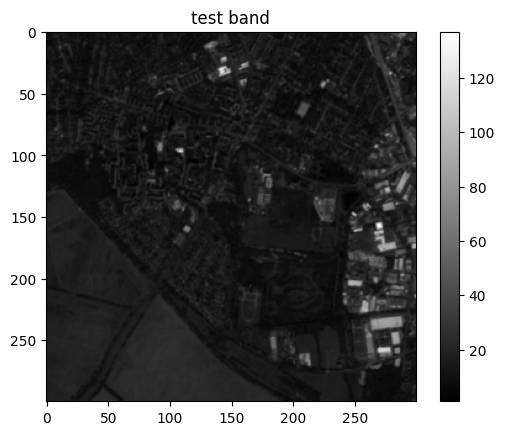

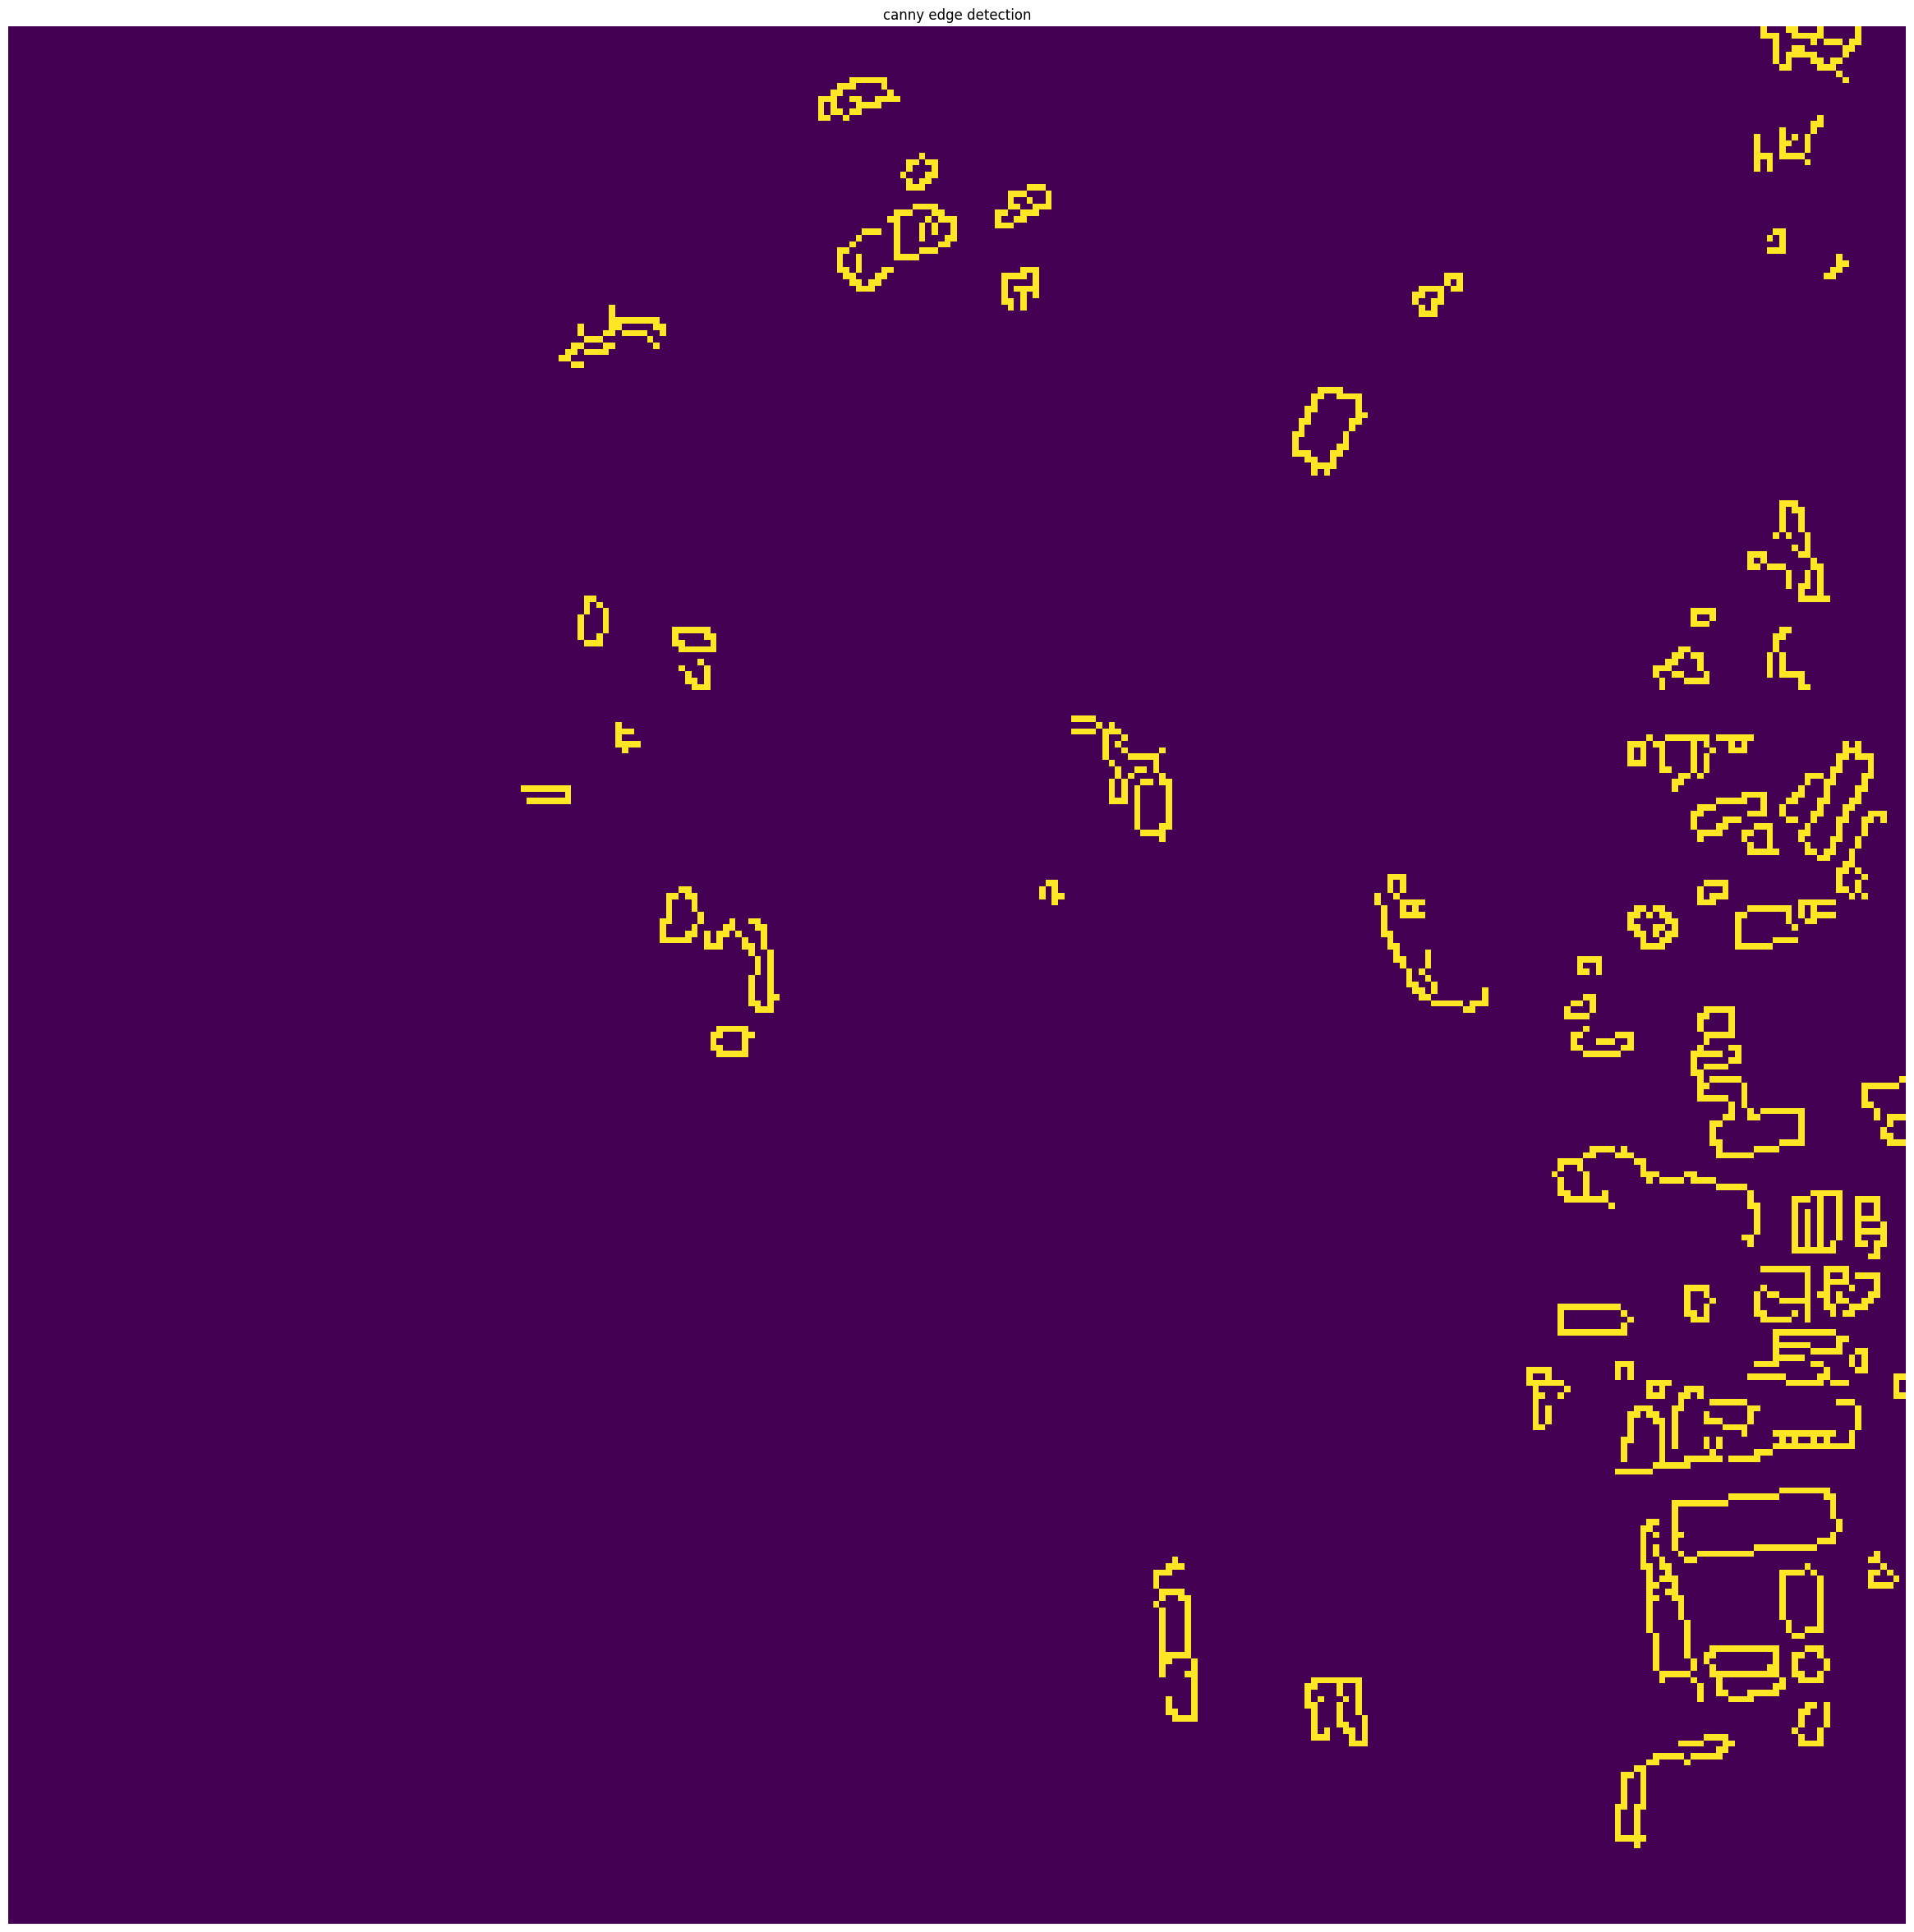

In [121]:
test_matrix = band1_3[9100:9400, 8700:9000]

low_threshold = 50
high_threshold = 150
edges = cv2.Canny(test_matrix, low_threshold, high_threshold)


plt.imshow(test_matrix, cmap='gray')
plt.title('test band')
plt.colorbar()

plt.figure(figsize=(30, 30))
plt.imshow(edges)
plt.title('canny edge detection')
plt.axis('off')

In [122]:
pitches = pd.read_csv("/home/lennart/Downloads/berlin_soccer_fields.csv")

In [123]:
from pyproj import Proj, transform

utm_proj = Proj(proj="utm", zone=33, datum="WGS84")
gcs_proj = Proj(proj="latlong", datum="WGS84")

eastings = []
northings = []

for _, row in pitches.iterrows():
    easting, northing = transform(gcs_proj, utm_proj, row["lon"], row["lat"])
    eastings.append(easting)
    northings.append(northing)

pitches["easting"] = eastings
pitches["northing"] = northings

/tmp/ipykernel_67578/524550437.py:10: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  easting, northing = transform(gcs_proj, utm_proj, row["lon"], row["lat"])


In [124]:
from joblib import Parallel, delayed
from shapely.geometry import Point

def process_pitch(pitch_row, sport):
    point = Point(pitch_row["easting"], pitch_row["northing"])
    matched_area = None

    for _, row in sport.iterrows():
        polygon = row["geometry"]
        if polygon.contains(point): # or polygon.distance(point) <= 100:
            matched_area = row.name
            break
    
    return matched_area

matched = Parallel(n_jobs=-1)(delayed(process_pitch)(pitch_row, sport) for _, pitch_row in pitches.iterrows())

In [125]:
len([x for x in matched if x is None]) / len(matched)

0.344954128440367

In [126]:
from PIL import Image

rgb_image = np.stack((band1_4, band1_3, band1_2), axis=-1)
image = Image.fromarray(rgb_image)
image.save("output_image.png")
image.show()

In [180]:
min_lon1 = coordinates1[:, 0].min()
max_lon1 = coordinates1[:, 0].max()
min_lat1 = coordinates1[:, 1].min()
max_lat1 = coordinates1[:, 1].max()
print(min_lon1, max_lon1, min_lat1, max_lat1)

min_lon2 = coordinates2[:, 0].min()
max_lon2 = coordinates2[:, 0].max()
min_lat2 = coordinates2[:, 1].min()
max_lat2 = coordinates2[:, 1].max()
print(min_lon2, max_lon2, min_lat2, max_lat2)

12.004760919773936 13.533307582680516 52.31348451566856 53.24022340763052
13.500940412105344 15.000599496448555 52.340808552427546 53.249626464996894


In [141]:
grid_size = band1_2.shape[0]

In [307]:
MATRIX_SIZE = 100
half_size = MATRIX_SIZE // 2

In [ ]:
def print_image(lat: float, lon: float):
    is_tile_1 = lon < 13.5  # border between both tiles

    if is_tile_1:
        grid_latitude = grid_latitude1
        grid_longitude = grid_longitude1
    else:
        grid_latitude = grid_latitude2
        grid_longitude = grid_longitude2

    distances = np.sqrt((grid_latitude - lat)**2 + (grid_longitude - lon)**2)

    closest_lat_index, closest_lon_index = np.unravel_index(np.argmin(distances), distances.shape)

    start_row = max(closest_lat_index - half_size, 0)
    end_row = min(closest_lat_index + half_size + 1, grid_size)

    start_col = max(closest_lon_index - half_size, 0)
    end_col = min(closest_lon_index + half_size + 1, grid_size)

    if is_tile_1:
        sub_band2 = band1_2[start_row:end_row, start_col:end_col]
        sub_band3 = band1_3[start_row:end_row, start_col:end_col]
        sub_band4 = band1_4[start_row:end_row, start_col:end_col]
    else:
        sub_band2 = band2_2[start_row:end_row, start_col:end_col]
        sub_band3 = band2_3[start_row:end_row, start_col:end_col]
        sub_band4 = band2_4[start_row:end_row, start_col:end_col]

    rgb_image = np.stack((sub_band4, sub_band3, sub_band2), axis=-1)
    rgb_image = np.clip(rgb_image * 1.5, 0, 255).astype(np.uint8)
    image = Image.fromarray(rgb_image)
    return image

In [312]:
for _, row in pitches.iterrows():
    image = print_image(lat=row["lat"], lon=row["lon"])
    image.save(os.path.join("facility_images", f"{row['osm_id']}.png"))

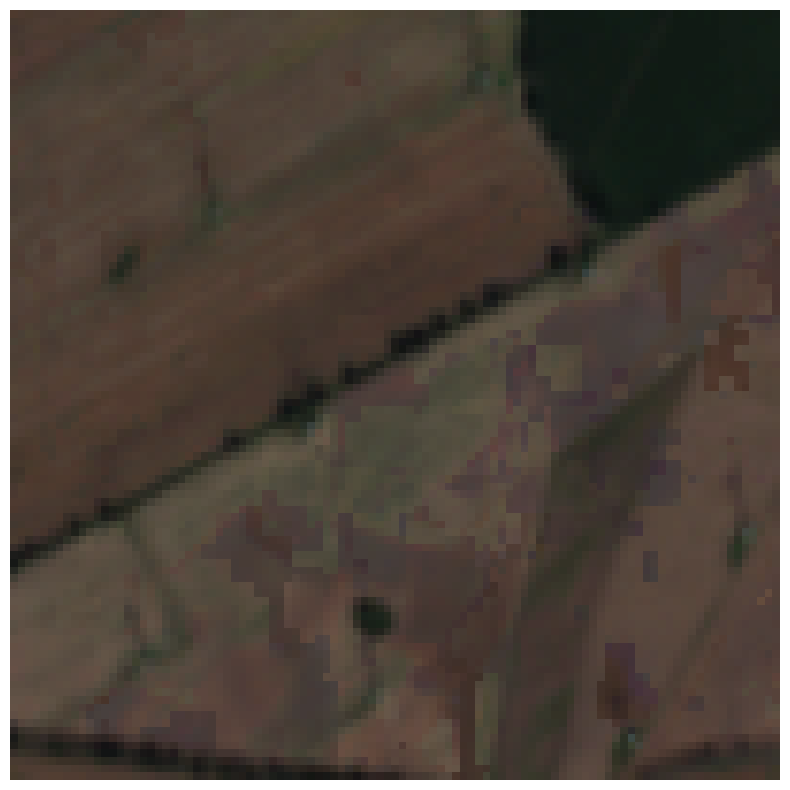

In [313]:
#img = print_image(pitches.iloc[200]["lat"], pitches.iloc[200]["lon"])
image = print_image(52.51461, 13.23945)

plt.figure(figsize=(10, 10))  # Width, height in inches
plt.imshow(image)
plt.axis('off')  # Optionally hide axes
plt.show()